# Introduction

This is a program to simulate the diffusion of 2 strains of PPR virus (II and IV) through animal mobility. The model will take account of the seasonality of movements and reproduction, as well as the fact that are 2 strains, with different  transmission parameters, circulating in the country. 
For this we consider an epidemiological SEIRD model with two age classes for each strain as in the mauritanian article. 
Transmission occurs at local level , inside a patch, whilst movement using a multinomial distribution for each patch. 
We use as patch the department level

## Packages

In [1]:
import pandas as pd
import numpy as np
import csv 
import matplotlib as mpl
from collections import defaultdict
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import nbimporter
import seaborn as sns

# Dynamical Model

We consider a SEIRD model where infected individuals can proceed to an exposed and then infectious compartment after contact  with an infectious dividual. We don't consider at this point any  distinction by species , age and gender. The only  distrinction that we consider is that depending on the infectious animal the individual can either  become infected by strain 2 or 4. 
Alpha is the ratio for infectivity between strain4 and strain2,
rho is the ratio for mortality,
eta is the transition rate from Immune at birth and susceptible (1/90),
sigma is the latency rate ,
gamma is the infectious rate,
vert is the probability of being born with maternal antibody (0.92),
nat is the fertility rate
mort is the natural mortality rate
beta is the transmission rate
parameters are stored in the file epidemiologicalparemters.csv

The equations for the model are stored in the notebook Epidemiologicalmodels and are input using the below function. The transfer functions , that is how the different animals are distributed among the nodes are  in the notebook Transferfunction

In [2]:
import Epidemiologicalmodels as efuncs
import Transferfunctions as tfuncs

I define a function epi_update_pop that is going to be applied to all the nodes of the network. We considered that movements occur weekly. The epidemic and demographic situation of the population is updated between two movements. The function take as inputs the name ofthe compartments (namestate), the number of the week (w0), and the node, and returns the compartiment distribution during the week (results) where the first index indicate the days from beginning. Since the excahnges between nodes occur every week, the epidemiological model runs before week ends and the results are store for each day

In [3]:
def epi_update_pop(namestates,w0,node):
    beta, mu,eta,mort, nat,p,alpha , rho, gamma,sigma,vert=node.beta,node.mu,node.eta,node.mortality[(w0%52)//5],node.fertility[(w0%52)//5],node.p,node.alpha ,node.rho,node.gamma,node.sigma,node.vert
    t = np.linspace(0,7,8)
    keylast=sorted(node.state.keys())[-1]
    status=node.state[keylast]
    y0=[status[k] for k in namestates]
    y = odeint(efuncs.seird_model2,y0,t,args=(beta, mu,eta,mort, nat,p,alpha , rho, gamma,sigma,vert))
    result={}
    for i in range(1,len(t)):
        result[7*w0+i]={}
        for j in range(0,len(namestates)):

            result[7*w0+i][namestates[j]]=int(round(y[i,j]))
    return result        

Function for transfer. La population of each compartment is updated wit the entry fom other nodes. The function goes through all the nodes in the network , cheack the  number of inidividuals that should displaced by compartment  and add in the movement destination. This movment is done once at the end of the week


The function resultdataframe transform the results from a list of classes to a datframe where each line contain for each node at each time the distribution of animals in each compartment. Using timeres =Week only  data at the end of the week are stored, otherwise all the data are stored

In [4]:
def resultdataframe(Senegal,timeres):
    result=pd.DataFrame()
    for a in Senegal:
        evol=Senegal[a].state
        temp=pd.DataFrame.from_dict(evol, orient='index')
        temp['Pop'] = temp.sum(axis=1)
        temp['time'] = temp.index
        temp['Dept'] = a

        if timeres=="Week":
            temp=temp[temp['time'] % 7==0]
        result=result.append(temp,ignore_index=True)
    result=result.sort_values(by=['time','Dept'])
    return result

# Preparing system

## Importing  network data

We use LPS data collected in 2014 for Senegal , with some extra data from Mauritnai to simulate the introduction of sources from foreign countries.  Data are stored either in csv or xlsx format and contain information about locations of origine and destination together with their administrative units associated, number of animals exchanged by type and month of the year (1...12)

In [5]:
datan = pd.read_csv(r'../1_Data/Network/Dynamic_Network_SmallRuminants2.csv',encoding='utf-8',sep=";") 
network = pd.DataFrame(datan, columns= ['Destination','Origin','Volume','Month','Week'])
#print(network)

## Associating nodes' characteristics


we import locations data and we aggregate at department level. We associated demographic  factors to the department depdending on their location 

In [6]:
datal = pd.read_csv(r'../1_Data/Network/nodes2.csv',sep=";",encoding="utf-8",dtype= {'Country':str, 'Region':str,'Dept':str,'goats':int,'sheep':int,'PR':int,'Pastoral':str}) 
locations = pd.DataFrame(datal,columns= ['Country','Region','Dept','PR','Pastoral'])
locations.head()



,Country,Region,Dept,PR,Pastoral
0,MAURITANIA,ASSABA,BARKEOL,185742,Sylvo
1,MAURITANIA,ASSABA,GUEROU,29275,Sylvo
2,MAURITANIA,ASSABA,KANKOSSA,96605,Sylvo
3,MAURITANIA,ASSABA,KIFFA,111635,Sylvo
4,GAMBIA,BANJUL,BANJUL,888,Agro


In [7]:
locations.loc[locations['Pastoral'].isnull(), 'Pastoral'] = "Agro"

In [8]:
demodata = pd.read_csv(r'../1_Data/Demography/demo_par.csv',sep=",",encoding="utf-8") 
demo = pd.DataFrame(demodata,columns= ['type','par','1','2','3','4','5','6','7','8','9','10','11','12'])
births=demo.loc[demo["par"]=="reprod",["type",'1','2','3','4','5','6','7','8','9','10','11','12']]
births=births.add_prefix('b_')
births.head()
deaths=demo.loc[demo["par"]=="hdea",["type",'1','2','3','4','5','6','7','8','9','10','11','12']]
deaths=deaths.add_prefix('d_')
deaths.head()
export=demo.loc[demo["par"]=="hoff",["type",'1','2','3','4','5','6','7','8','9','10','11','12']]
export=export.add_prefix('e_')
export.head()
#deaths=demo[demo["par"]=="hdea"]
#export=demo[demo["par"]=="hoff"]


,e_type,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,e_10,e_11,e_12
2,Agro,0.000853,0.001435,0.001230,0.001572,0.002458,0.003663,0.003310,0.002095,0.002166,0.001588,0.000811,0.001145
5,Sylvo,0.002379,0.001322,0.001092,0.001300,0.002138,0.002521,0.003648,0.002594,0.001265,0.001189,0.001275,0.001948


In [9]:
dept=locations.merge(births,how="inner",left_on="Pastoral",right_on="b_type")
dept=dept.merge(deaths,how="inner",left_on="Pastoral",right_on="d_type")
dept=dept.merge(export,how="inner",left_on="Pastoral",right_on="e_type")
dept.shape[0]

61

We import epidemiological parmetrs from the csv file 


In [10]:
glob = globals()
loc = locals()

    
with open("../1_Data/Epidemio/Epidemicpar.csv", "r") as f:
    for line in f:
        key_val = line.strip().split(";")
       
        glob[key_val[0]] = float(key_val[1])

In [11]:
mu0

0.4

I create a class called NodesData that contains all the demographic information of the department + the fluxes towards the neighbors by month and the function for initialise the  compartiments of the epidemiological model. Inside the  node sevral function have been defined that  are used:

 - add_neighbour(self, month,neighbour,volume) the function creates 2  dictionary (volume_month  and neighbours)using the  network data and consider the node as origin of the movements: the first one stores , for each month the number of outgoing animals; the second one , for each month and each directly connected destination the number of animals that are exported
 - normalise. use the previous 2 dictionaries to create a new  one containing tfor each month and each neighbor the fraction animals  moving to the location. this will be used in the second step to distibute  animals
 - initialise_state(self,namestates) taking the number of states distibute the populations in the compartments at the beginning of the epidemics
 - initialise_epidemics(self,seeds2,seeds4) for selected nodes add the number of  individuals infected by strain2 or strain4
 - update_state(self,res,timeres). external function for the model  take the information of the nodes, run the model  and update the distribution. The function update-state add the results  of the model. The parameter timeres  , define if we want to add all estimations  day by day of th  compartment  or just the one at the end of the week.
 - prepare_transfer(self,res,w0,moving) this function prepares the  number of animals in each state that should be moved (stored in depart_neighb) and subtract from the corresponding compartment. res  is the results from the epidemic model. We are moving one a week  so we are interested only in the results of the last  day. w0 is the week counter, moving is the list of compartiments with alive animals taht are moved.
 - add_epi_par , add the epidemic parameters to each node
 

In [12]:
class NodesData:

    def __init__(self,country,region, name, pop,fertility,mortality,neighbours=None):
        self.country,self.region,self.name, self.pop = country,region,name,pop
        self.fertility=np.reshape(fertility, 12)
        self.mortality=np.reshape(mortality, 12)
        self.neighbours = {}
        self.norm_neigh={}
        self.volume_week={}
        self.state={}
        self.depart={}
        self.depart_neighb={}
        self.state={}
    def add_epi_par(self,alpha,beta,eta,gamma,mu,rho,sigma,p,vert):
        self.alpha,self.beta,self.eta,self.gamma,self.mu,self.rho,self.sigma,self.p,self.vert=alpha,beta,eta,gamma,mu,rho,sigma,p,vert

    def add_neighbour(self, week,neighbour,volume):
        if week in self.neighbours:
            self.neighbours[week][neighbour]=volume
            self.volume_week[week]+=volume
        else:
            self.neighbours[week]={}
            self.neighbours[week][neighbour]=volume
            self.volume_week[week]={}
            self.volume_week[week]=volume
    def __str__(self): 
        return self.neighbours

    def __str__(self): 
        
        return self.volume_week  
    def normalise(self):
        for m in self.neighbours :
            self.norm_neigh[m]={}
            for n in self.neighbours[m] :
                self.norm_neigh[m][n] = float(self.neighbours[m][n])/self.volume_week[m]
    
    def __str__(self):
        
        return self.norm_neigh
        #self.volume_month =self.neighbours.groupby('month').volume.agg('sum')
    #### Partie epidemiologique#######
    def initialise_state(self,namestates):
        self.state[0]={}
        for s in namestates:
            self.state[0][s]=0
        self.state[0]["S"]=self.pop
    def initialise_epidemic(self,seeds2,seeds4):
        self.state[0]["S"]=self.state[0]["S"]-(seeds2+seeds4)    
        self.state[0]["I2"]=seeds2 
        self.state[0]["I4"]=seeds4
    def update_state(self,res,timeres):
        if timeres=="All":
            self.state.update(res)
        else:
            lastday=res.keys()[-1]
            self.state[lastday]=res[lastday]
    def __str__(self):
        return self.state 
    def reinitialize(self):
        self.state={}
    ####################
    #### partie transfer
    def prepare_transfer(self,res,w0,moving):
       
        if w0%52 in self.volume_week.keys():
            vol_week=self.volume_week[w0%52]
            lastday=res.keys()[-1]
            # percentage in each compartment that should move
            mov0=sum(res[lastday][x] for x in moving)
            ratio=float(vol_week)/float(mov0)
           
            #self.depart=res[lastday].update({x: ratio * res[lastday][x] for x in moving})
            for x in moving:
                self.depart[x]=int(round(ratio*(res[lastday][x])))
                #print(x,self.depart[x],ratio*(res[lastday][x]))
            #updating compartment after leaving
                self.state[lastday][x]=(self.state[lastday][x]-self.depart[x])
            # creating dictionary with animals that should move to each neighboru
            for n in self.norm_neigh[w0%52]:
                self.depart_neighb[n]={}
                for x in moving:
                   
                    self.depart_neighb[n][x]= self.depart[x] * self.norm_neigh[w0%52][n]
    def __str__(self):
        return self.depart_neighb

We create ditionary of  classes , whose elements are classess that contains information  of the Senegalese Department. 
The dictionary is called Senegal

In [13]:
Senegal = {a.Dept:NodesData(a.Country,a.Region,a.Dept, a.PR,dept.loc[dept['Dept']==a.Dept,'b_1':'b_12'].values,dept.loc[dept['Dept']==a.Dept,'d_1':'d_12'].values) for a in dept.itertuples()}

Starting from the network dataframe we  add for each  origin department and for each month the list of destination departments and the volume exchanged

In [14]:
{Senegal[a.Origin].add_neighbour(a.Week,a.Destination,a.Volume) for a in network.itertuples()}

{None}

In [15]:
{Senegal[a].normalise() for a in Senegal}

{None}

## Simulations


We create the list of compartments in the model + the ist of  compartiments that will be moved  among neighbors. We initialise the  compartiments to be 0 except the susceptible , and for a node we put 100 infected of type 2. We simulate 2 years , and  repeat the simulation 10 times

In [16]:
namestates=("Imm","S","E2","E4","I2","I4","R2","R4", "D2","D4")
moving=("S","E2","E4","I2","I4","R2","R4")

In [17]:
result = []

for t in range(0,10):
    print(t)
    alpha=max(alpha0*(1+(t*0.1-0.5)),0)
    beta=max(beta0*(1+(t*0.1-0.5)),0)
    gamma=gamma0
    eta=eta0
    mu=mu0
    rho=rho0
    sigma=sigma0
    p=p0
    vert=vert0
    {Senegal[a].add_epi_par(alpha,beta,eta,gamma,mu,rho,sigma,p,vert) for a in Senegal}
    {Senegal[a].initialise_state(namestates) for a in Senegal}
    Senegal['MATAM'].initialise_epidemic(100,0)

    for w0 in range(0,208):
        for a in Senegal:
            res=epi_update_pop(namestates,w0,Senegal[a]) 

            Senegal[a].update_state(res,"All") 
            Senegal[a].prepare_transfer(res,w0,moving)
        for a in Senegal:  
            tfuncs.transfer_func(moving,a,Senegal)
    res2   =resultdataframe(Senegal,"All")  
    res2['iter']=t
    result.append(res2 )  
    {Senegal[a].reinitialize() for a in Senegal}

0
1
2
3
4
5
6
7
8
9


In [18]:
result_df = pd.concat(result, ignore_index=True)


## Plots

The first type of plot , plot  the total number of individuals in each compartment

In [19]:

epidemics=result_df.groupby(['iter','time'],as_index=False).agg(
    {
         'S':sum,    # Sum pop
         'I2': sum,  # 
         'I4': sum,
         'D2': sum,
         'D4': sum,
         'Pop': sum
    }
)

epiplot=pd.melt(epidemics, id_vars=['iter','time'], value_vars=['Pop','S', 'I2','I4','D2','D4'])

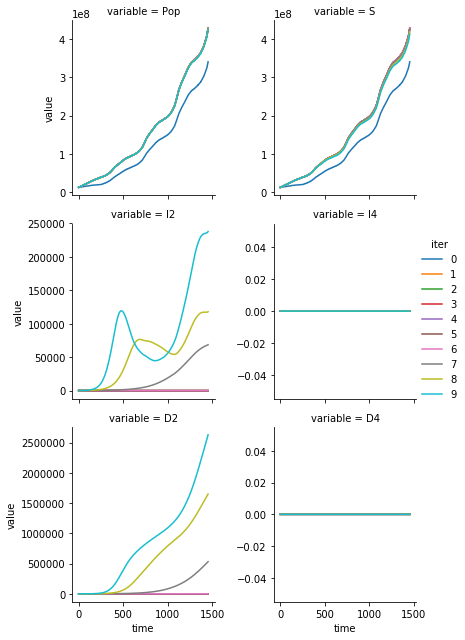

In [20]:
g = sns.FacetGrid(epiplot, col='variable', hue='iter', height=3, col_wrap=2,sharey=False)
g = g.map(sns.lineplot, 'time', 'value', ci=None).add_legend()